In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
import folium
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.colors as colors
from collections import defaultdict

In [4]:
df = pd.read_csv('data_processed2.csv')
df.info() # check empty or Null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58625 entries, 0 to 58624
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     58625 non-null  float64
 1   Longtitude   58625 non-null  float64
 2   0            58625 non-null  int64  
 3   Altitute     58625 non-null  float64
 4   Date         58625 non-null  float64
 5   Date string  58625 non-null  object 
 6   Time         58625 non-null  object 
 7   UID          58625 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 3.6+ MB


In [5]:
# correct spelling
df = df.rename(columns={'Longtitude': 'Longitude'})

## Bounding box and outlier deletion

In [7]:
# Before outlier removal
min_latitude_before = df['Latitude'].min()
max_latitude_before = df['Latitude'].max()

min_longitude_before = df['Longitude'].min()
max_longitude_before = df['Longitude'].max()

print(min_latitude_before, max_latitude_before)
print(min_longitude_before, max_longitude_before)

1.274887 64.751993
-179.44559 175.61915


In [8]:
def show_map(df, mode):
    fig = go.Figure(data=go.Scattergeo(
            lon = df['Longitude'],
            lat = df['Latitude'],
            mode = 'markers',
            marker_color = df['UID'],
            ))
    if mode == 'asia':
        fig.update_geos(scope='asia')

    fig.show()

In [ ]:
# get the bounding box -- 95% pertentile
# min_index = int(len(df) * 0.025)
# max_index = int(len(df) * 0.975)
# print(min_index, max_index)
# sorted_latitude = df['Latitude'].sort_values(ignore_index=True)
# sorted_longitude = df['Longitude'].sort_values(ignore_index=True)

# min_latitude = sorted_latitude[min_index]
# max_latitude = sorted_latitude[max_index]

# min_longitude = sorted_longitude[min_index]
# max_longitude = sorted_longitude[max_index]

In [ ]:
print(min_latitude, max_latitude)
print(min_longitude, max_longitude)

In [9]:
# use beijing city
beijing_min_longitude, beijing_max_longitude = 115.416827, 117.508251
beijing_min_latitude, beijing_max_latitude = 39.442078, 41.058964

filtered_df = df[(df['Latitude'] < beijing_max_latitude) & (df['Latitude'] > beijing_min_latitude) & (df['Longitude'] < beijing_max_longitude) & (df['Longitude'] > beijing_min_longitude)]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,Latitude,Longitude,0,Altitute,Date,Date string,Time,UID
0,39.984356,116.304909,0,305.000000,39744.125000,2008-10-23,03:00:00,0
1,39.991288,116.320445,0,66.000000,39744.184745,2008-10-23,04:26:02,0
2,40.009351,116.321916,0,158.000000,39744.418102,2008-10-23,10:02:04,0
3,40.006747,116.318549,0,7584.000000,39744.435127,2008-10-23,10:26:35,0
4,40.008718,116.322383,0,117.000000,39745.101435,2008-10-24,02:26:04,0
...,...,...,...,...,...,...,...,...
48887,39.980150,116.299783,0,396.981627,39494.375069,2008-02-16,09:00:06,181
48888,39.989933,116.302783,0,383.858268,39495.042720,2008-02-17,01:01:31,181
48889,39.977050,116.310617,0,383.858268,39495.060035,2008-02-17,01:26:27,181
48890,39.983433,116.308350,0,183.727034,39495.186030,2008-02-17,04:27:53,181


## Remove out-ranged daily records

In [10]:
def get_frequency(df):
    day_record_count = []
    users = df['UID'].unique()
    # check the records for a day
    for user in users:
        dates = df[df['UID'] == user]['Date string'].unique()
        for date in dates:
            num_record = len(df[(df['UID'] == user) & (df['Date string'] == date)])
            day_record_count.append(num_record)
    
    frequency = {}
    for element in day_record_count:
        if element in frequency:
            frequency[element] += 1
        else:
            frequency[element] = 1
    return frequency
    
freq = get_frequency(filtered_df)
print(freq)

{4: 1002, 1: 1833, 3: 1293, 5: 694, 8: 395, 2: 1836, 6: 561, 31: 4, 20: 39, 15: 81, 9: 325, 7: 468, 11: 206, 12: 158, 14: 124, 16: 77, 22: 26, 21: 39, 17: 52, 13: 136, 18: 52, 10: 228, 25: 6, 24: 11, 23: 19, 34: 1, 30: 2, 19: 49, 26: 8, 36: 3, 28: 2, 27: 5, 37: 2, 32: 2, 43: 1, 45: 1, 41: 1, 29: 5}


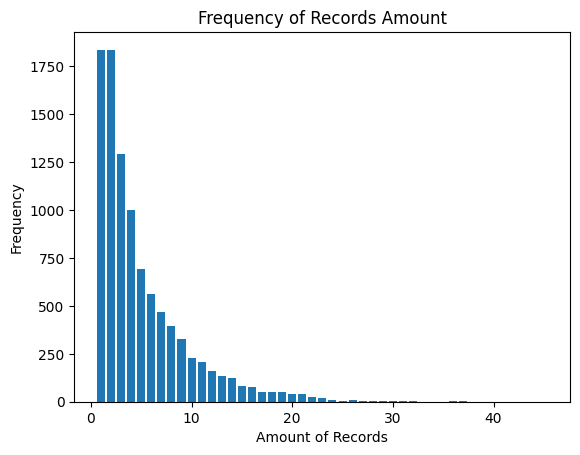

In [11]:
x_values = list(freq.keys())
y_values = list(freq.values())

# Create the bar plot
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel('Amount of Records')
plt.ylabel('Frequency')
plt.title('Frequency of Records Amount')

# Show the plot
plt.show()

In [12]:
def remove_out_ranged(min_range, max_range, df):
    day_record_count = []
    users = df['UID'].unique()
    # check the records for a day
    for user in users:
        dates = df[df['UID'] == user]['Date string'].unique()
        for date in dates:
            num_record = len(df[(df['UID'] == user) & (df['Date string'] == date)])
            if num_record < min_range or num_record > max_range:
                df = df.drop(df[(df['UID'] == user) & (df['Date string'] == date)].index)
    df = df.reset_index(drop=True)
    return df

In [13]:
ranged_filtered_df = remove_out_ranged(5, 50, filtered_df)
ranged_filtered_df

,Latitude,Longitude,0,Altitute,Date,Date string,Time,UID
0,40.011595,116.296916,0,114.000000,39749.041678,2008-10-28,01:00:01,0
1,40.007690,116.295715,0,73.000000,39749.059734,2008-10-28,01:26:01,0
2,40.006310,116.296586,0,70.000000,39749.085428,2008-10-28,02:03:01,0
3,40.010108,116.300753,0,180.000000,39749.101400,2008-10-28,02:26:01,0
4,40.007635,116.319636,0,-197.000000,39749.210440,2008-10-28,05:03:02,0
...,...,...,...,...,...,...,...,...
35495,39.985017,116.309700,0,173.884514,39448.126134,2008-01-01,03:01:38,181
35496,39.964783,116.354900,0,475.721785,39448.143530,2008-01-01,03:26:41,181
35497,39.961183,116.358767,0,269.028871,39448.251840,2008-01-01,06:02:39,181
35498,39.960700,116.360033,0,213.254593,39448.272836,2008-01-01,06:32:53,181


In [14]:
len(ranged_filtered_df['UID'].unique())

150

In [15]:
num_users = len(ranged_filtered_df['UID'].unique())
cmap = cm.get_cmap('tab10', num_users)
user_colors = defaultdict(lambda: cmap(len(user_colors)))

m = folium.Map(location=[39.9, 116.4], zoom_start=9, tiles="cartodb positron")

for i, row in df.iterrows():
    color = colors.rgb2hex(user_colors[row['UID']])
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        icon=folium.Icon(color=color),
    ).add_to(m)

# Save the map
m.save('beijing.html')

c:\Users\Lik\anaconda3\envs\yolov5\lib\site-packages\ipykernel_launcher.py:11: UserWarning: color argument of Icon should be one of: {'beige', 'lightgray', 'lightred', 'green', 'blue', 'lightblue', 'white', 'orange', 'darkred', 'lightgreen', 'darkgreen', 'red', 'gray', 'black', 'purple', 'darkpurple', 'pink', 'cadetblue', 'darkblue'}.
  # This is added back by InteractiveShellApp.init_path()


## Add grid

In [ ]:
range_latitude = max_latitude - min_latitude
range_longitude = max_longitude - min_longitude
print(range_latitude, range_longitude)

In [ ]:
# define every grid is a 1 by 1 square


In [16]:
def aggregation(df, user, date):
    aggr_df = df[df['UID'] == user & df['Date string'] == date]
    aggr_df.sort_values(by=['Date'])
    return aggr_df

## First seven days' trajectory for user 0

In [17]:
print(ranged_filtered_df[ranged_filtered_df['UID']==0]['Date string'].drop_duplicates().values)

['2008-10-28' '2008-11-04' '2008-11-11' '2008-11-14' '2009-03-30'
 '2009-03-31' '2009-04-03' '2009-04-04' '2009-04-05' '2009-04-06'
 '2009-04-10' '2009-04-11' '2009-04-12' '2009-04-13' '2009-04-14'
 '2009-04-15' '2009-04-16' '2009-04-19' '2009-04-20' '2009-04-24'
 '2009-04-25' '2009-04-26' '2009-04-27' '2009-04-29' '2009-04-30'
 '2009-05-01' '2009-05-02' '2009-05-03' '2009-05-07' '2009-05-12'
 '2009-05-18' '2009-05-21' '2009-05-25' '2009-05-26' '2009-05-27'
 '2009-05-28' '2009-05-30' '2009-06-02' '2009-06-03' '2009-06-04'
 '2009-06-05' '2009-06-06' '2009-06-08' '2009-06-09' '2009-06-11'
 '2009-06-13' '2009-06-14' '2009-06-15' '2009-06-16' '2009-06-17'
 '2009-06-18' '2009-06-19' '2009-06-21' '2009-06-23' '2009-06-29'
 '2009-06-30' '2009-07-02' '2009-07-03' '2009-07-05']


In [18]:
users = filtered_df['UID'].unique()
sum_traj = 0
for user in users:
    sum_traj += len(ranged_filtered_df[ranged_filtered_df['UID']==0]['Date string'].drop_duplicates().values)
print(sum_traj)

10502


In [19]:
# find the same day how many users are in this day
unique_days = filtered_df['Date string'].unique()
date_traj_dict = {}
for day in unique_days:
    date_traj_dict[day] = 0

for user in users:
    user_dates = filtered_df[filtered_df['UID'] == user]['Date string'].unique()
    for day in user_dates:
        date_traj_dict[day] += 1

threshold = 10
date_availble = []
for day in date_traj_dict:
    if date_traj_dict[day] >= threshold:
        date_availble.append(day)
        
print(len(date_availble))
print(date_availble)

351
['2008-10-23', '2008-10-24', '2008-10-26', '2008-10-27', '2008-10-28', '2008-10-29', '2008-11-03', '2008-11-04', '2008-11-10', '2008-11-11', '2008-11-12', '2008-11-13', '2008-11-14', '2008-11-15', '2008-11-17', '2008-11-18', '2008-11-19', '2008-11-20', '2008-11-21', '2008-11-22', '2008-11-23', '2008-12-01', '2008-12-03', '2008-12-04', '2008-12-10', '2008-12-12', '2009-03-30', '2009-03-31', '2009-04-01', '2009-04-02', '2009-04-03', '2009-04-04', '2009-04-05', '2009-04-06', '2009-04-09', '2009-04-10', '2009-04-11', '2009-04-12', '2009-04-13', '2009-04-14', '2009-04-15', '2009-04-16', '2009-04-17', '2009-04-18', '2009-04-19', '2009-04-20', '2009-04-21', '2009-04-22', '2009-04-23', '2009-04-24', '2009-04-26', '2009-04-27', '2009-04-28', '2009-04-29', '2009-04-30', '2009-05-01', '2009-05-02', '2009-05-03', '2009-05-04', '2009-05-05', '2009-05-06', '2009-05-07', '2009-05-08', '2009-05-09', '2009-05-10', '2009-05-11', '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15', '2009-05-16', '

In [26]:
# obtain the data for user 0 in several consecutive days (e.g. user 0, from 2009-04-09 to 2009-04-15)
user_date_range = ['2009-04-10', '2009-04-11', '2009-04-12', '2009-04-13', '2009-04-14', '2009-04-15', '2009-04-16']
# user_date_range = ['2009-04-10']
UID = 0
user_weekly_trajectory_df = ranged_filtered_df[(ranged_filtered_df['UID'] == UID) & (ranged_filtered_df['Date string'].isin(user_date_range))]
user_weekly_trajectory_df = user_weekly_trajectory_df.reset_index(drop=True)

weekly_trajectory_line = []
daily_trajectory = []
current_date = user_date_range[0]

for i, row in user_weekly_trajectory_df.iterrows():
    if row['Date string'] != current_date:
        weekly_trajectory_line.append(daily_trajectory)
        daily_trajectory = []
        current_date = row['Date string']
    if i >= len(user_weekly_trajectory_df) - 1:
        daily_trajectory.append((row['Latitude'], row['Longitude'], row['Time']))
        weekly_trajectory_line.append(daily_trajectory)
        break
    daily_trajectory.append((row['Latitude'], row['Longitude'], row['Time']))
print(weekly_trajectory_line)

[[(39.999748, 116.325489, '02:26:00'), (40.000017, 116.327485, '07:33:38'), (39.996271, 116.299381, '08:00:03'), (39.924572, 116.268747, '08:26:03'), (39.763277, 116.297391, '13:05:13'), (39.855453, 116.277075, '13:26:03'), (39.995047, 116.326441, '14:00:03'), (39.999975, 116.327386, '17:03:57')], [(40.010056, 116.322318, '05:26:03'), (39.998493, 116.321585, '07:26:02'), (39.992813, 116.289597, '08:00:02'), (39.883988, 116.203385, '08:26:02'), (39.763374, 116.297387, '13:05:14'), (39.826135, 116.283854, '13:26:04'), (39.991058, 116.315291, '14:00:02')], [(40.000017, 116.327479, '07:33:03'), (39.99443, 116.298239, '08:00:04'), (39.89574, 116.240603, '08:26:04'), (39.763433, 116.297462, '13:05:10'), (39.823255, 116.283871, '13:26:00'), (39.990987, 116.315074, '14:00:00')], [(40.000278, 116.327658, '07:33:28'), (39.996238, 116.298736, '08:00:03'), (39.895174, 116.204883, '08:26:03'), (39.763201, 116.297439, '13:05:13'), (39.829266, 116.283946, '13:26:03'), (39.991423, 116.327097, '14:00:0

In [28]:
plot_beijing_line(weekly_trajectory_line)

## Plot helping functions here

In [21]:
def plot_beijing_scatter(trajectory):
    m = folium.Map(location=[39.9, 116.4], zoom_start=9, tiles="cartodb positron")
    for daily_record in trajectory:
        for (latitude, longitude) in daily_record:
            folium.Marker((latitude, longitude)).add_to(m)
    m.save("beijing_scatter.html")

In [27]:
def plot_beijing_line(trajectory):
    m = folium.Map(location=[39.9, 116.4], zoom_start=9, tiles="cartodb positron")
    colors = ['gray', 'black', 'lightred', 'cadetblue', 'red', 'darkblue', 'green', 'lightblue', 'beige', 'blue', 'lightgreen', 'white', 'orange', 'darkgreen', 'purple', 'darkred', 'pink', 'darkpurple', 'lightgray']
    for day in range(len(trajectory)):
        line = []
        for location in range(len(trajectory[day])):
            popup = f"Day {day+1} - {location+1} - {trajectory[day][location][2]}"
            loc = f"{location+1}"
            line.append(trajectory[day][location][0:2])
            folium.Marker(location=trajectory[day][location][0:2],
                         tooltip=popup,
                         icon=folium.Icon(icon=loc, prefix='fa', color=colors[day])
                         ).add_to(m)
            
        folium.PolyLine(line, color="red", weight=2.5, opacity=1).add_to(m)
    m.save("beijing_line.html")

In [ ]:
plot_beijing_line([(39,116),(38, 115), (39,114)])

In [75]:
a = 100
str(a)

'100'

In [24]:
ranged_filtered_df.to_csv('data_processed3.csv', encoding='utf-8', index=False)